In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchsummary import summary

from skimage.util import random_noise
from tqdm.notebook import tqdm
from functools import partial

In [2]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# resize all images to 128x128
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats/data
!kaggle competitions download -c dogs-vs-cats

In [5]:
class Cats(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [6]:
# set train and test datasets
cats_train = Cats('catsdogs/train/Cat', transform=transform)
cats_test = Cats('catsdogs/test/Cat', transform=transform)

In [7]:
len(cats_train), len(cats_test)

(9998, 2501)

In [8]:
cats_train[0].shape, cats_train[0]

(torch.Size([3, 128, 128]),
 tensor([[[0.8000, 0.8157, 0.8275,  ..., 0.9608, 0.9569, 0.9412],
          [0.8000, 0.8157, 0.8275,  ..., 0.9647, 0.9569, 0.9451],
          [0.8000, 0.8157, 0.8275,  ..., 0.9647, 0.9569, 0.9529],
          ...,
          [0.6196, 0.6235, 0.6275,  ..., 0.0118, 0.0118, 0.0078],
          [0.6078, 0.6118, 0.6196,  ..., 0.0118, 0.0118, 0.0118],
          [0.5961, 0.6039, 0.6118,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.6471, 0.6627, 0.6745,  ..., 0.8118, 0.8000, 0.7882],
          [0.6471, 0.6627, 0.6745,  ..., 0.8157, 0.8078, 0.7922],
          [0.6471, 0.6627, 0.6745,  ..., 0.8235, 0.8118, 0.8000],
          ...,
          [0.4902, 0.4941, 0.4941,  ..., 0.0157, 0.0157, 0.0118],
          [0.4863, 0.4902, 0.4980,  ..., 0.0118, 0.0118, 0.0118],
          [0.4745, 0.4824, 0.4902,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.3451, 0.3608, 0.3725,  ..., 0.4941, 0.4784, 0.4784],
          [0.3451, 0.3608, 0.3725,  ..., 0.5020, 0.4863, 0.4824],
          [0

In [9]:
# create torch dataloaders
train_loader = DataLoader(cats_train, batch_size=64, shuffle=True)
test_loader = DataLoader(cats_test, batch_size=64, shuffle=True)

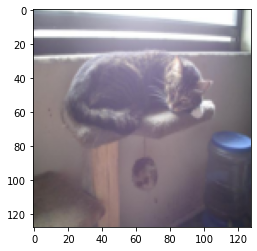

In [10]:
images = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0));

In [11]:
images.shape

torch.Size([64, 3, 128, 128])

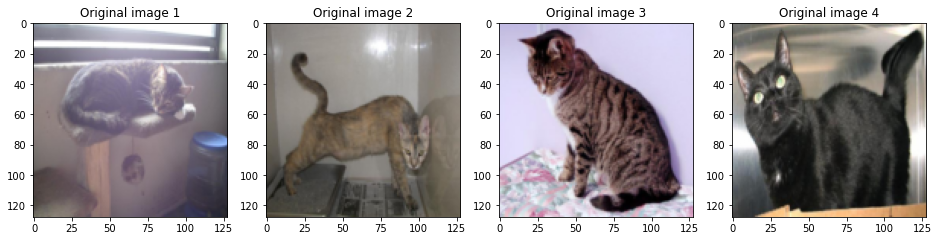

In [12]:
plt.figure(figsize=(16,8))
for idx in range(4):
    plt.subplot(1,4,idx+1)
    plt.title(f'Original image {idx+1}')
    plt.imshow(images[idx].permute(1,2,0));

In [13]:
# function to add some noise to images
def add_gauss(imgs):
    return torch.tensor(random_noise(imgs, mode='gaussian', mean=0, var=0.04, clip=True))
gauss_img = add_gauss(images)

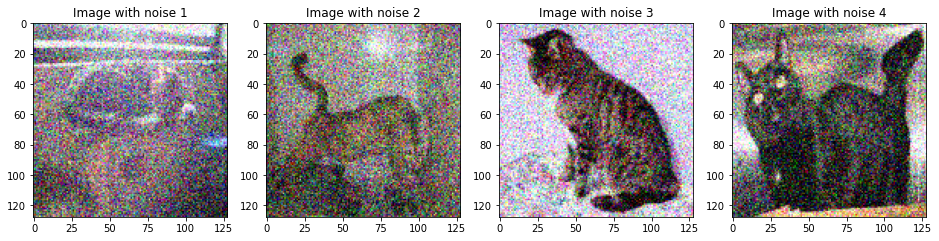

In [14]:
plt.figure(figsize=(16,8))
for idx in range(4):
    plt.subplot(1,4,idx+1)
    plt.title(f'Image with noise {idx+1}')
    plt.imshow(gauss_img[idx].permute(1,2,0));

In [45]:
# function to save original, noised and denoised images
os.makedirs('cats_denoise', exist_ok=True)
def save_samples(x, y_true, y_predicted, epoch):
    
    y_true = y_true.cpu()
    x = x.cpu()
    y_predicted = y_predicted.cpu()
    
    orig_name = 'original-images-{0:0=4d}.png'.format(epoch)
    noise_name = 'images-with-noise-{0:0=4d}.png'.format(epoch)
    denoised_name = 'decoded-images-{0:0=4d}.png'.format(epoch)
    
    save_image(y_true, os.path.join('cats_denoise', orig_name), nrow=8)
    save_image(x, os.path.join('cats_denoise', noise_name), nrow=8)
    save_image(y_predicted, os.path.join('cats_denoise', denoised_name), nrow=8)
    
    print(f'Saving images for epoch {epoch}')

In [56]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(history['train_losses'], label='train loss')
    ax.plot(history['test_losses'], label='test loss')
    ax.set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax.grid(grid)
    ax.legend()
    plt.show()

def torch_train(model, epochs, history=None, plot_every=None, progress=True):
    history = history or {
        'train_losses': [],
        'test_losses': []
    }
    # фиксируем параметры tqdm
    tqdm_ = partial(tqdm,
                    disable=not progress, # не показывать бар вообще
                    leave=False) # убрать бар после окончания
    
    start_epoch = len(history['train_losses'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'epoch {epoch}')
        # переводим модель в режим тренировки
        model.train()
        for batch, x_train_batch in enumerate(tqdm_(train_loader, desc='train')):
            noise_images = add_gauss(x_train_batch).to(device) # images with noise(our 'X')
            x_train_batch = x_train_batch.to(device) # original images (our 'y_true')
            
            # Forward pass: compute predicted y by passing x to the model
            
            y_pred = model(noise_images.float())
            
            # Compute loss
            loss = loss_fn(y_pred, x_train_batch.float())
            
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # clip gradients to avoid 'exploding gradients' problem
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.8, norm_type=2)

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()

        # переводим в модель режим предсказания
        model.eval()
        # compute losses on train dataset
        batch_losses = []
        for batch, x_train_batch in enumerate(tqdm_(train_loader, desc='eval')):
            noise_images = add_gauss(x_train_batch).to(device)
            x_train_batch = x_train_batch.to(device)
            # set inference_mode
            with torch.inference_mode():
                y_pred = model(noise_images.float())
                batch_losses.append(loss_fn(y_pred, x_train_batch.float()).cpu().numpy())
        history['train_losses'].append(np.mean(batch_losses))
        
        # compute losses on test dataset
        batch_losses = []
        for batch, x_test_batch in enumerate(tqdm_(test_loader, desc='test')):
            noise_images = add_gauss(x_test_batch).to(device)
            x_test_batch = x_test_batch.to(device)
            # set inference_mode
            with torch.inference_mode():
                y_pred = model(noise_images.float())
                batch_losses.append(loss_fn(y_pred, x_test_batch.float()).cpu().numpy())
        history['test_losses'].append(np.mean(batch_losses))
        
        # printing losses
        print(f'train: loss {history["train_losses"][-1]:.4f}\n'
              f'test: loss {history["test_losses"][-1]:.4f}')
        
        # saving images for the last x_test_batch of the epoch
        save_samples(x=noise_images, y_true=x_test_batch, y_predicted=y_pred, epoch=epoch)
        
        if plot_every and epoch % plot_every == 0:
            plot_history(history)
        else:
            print()
    
    # not to plot double
    if not plot_every or epoch % plot_every > 0:
        plot_history(history)
    
    # to show images from the last test batch
    x_test_batch = x_test_batch.cpu()
    noise_images = noise_images.cpu()
    y_pred = y_pred.cpu()
    plt.figure(figsize=(16,8))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Original image {idx+1}')
        plt.imshow(x_test_batch[idx].permute(1,2,0))
    plt.figure(figsize=(16,8))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Image with noise {idx+1}')
        plt.imshow(noise_images[idx].permute(1,2,0))
    plt.figure(figsize=(16,8))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Decoded image {idx+1}')
        plt.imshow(y_pred[idx].permute(1,2,0))

    return history

In [57]:
# set class of our autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                                     nn.Conv2d(3, 32, kernel_size=3, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(32),
                                     
                                     nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     
                                     nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     
                                     nn.MaxPool2d(kernel_size=2, stride=2))
       
        self.decoder = nn.Sequential(
                                    nn.Upsample(scale_factor=2),
            
                                    nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm2d(64),
            
                                    nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm2d(32),
            
                                    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1),
                                    nn.Sigmoid())


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [60]:
model = ConvAutoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
       BatchNorm2d-6         [-1, 64, 128, 128]             128
            Conv2d-7         [-1, 64, 128, 128]          36,928
              ReLU-8         [-1, 64, 128, 128]               0
       BatchNorm2d-9         [-1, 64, 128, 128]             128
        MaxPool2d-10           [-1, 64, 64, 64]               0
         Upsample-11         [-1, 64, 128, 128]               0
  ConvTranspose2d-12         [-1, 64, 128, 128]          36,928
             ReLU-13         [-1, 64, 128, 128]               0
      BatchNorm2d-14         [-1, 64, 1

epoch 1


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0030
test: loss 0.0030
Saving images for epoch 1

epoch 2


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0027
test: loss 0.0027
Saving images for epoch 2

epoch 3


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0028
test: loss 0.0028
Saving images for epoch 3

epoch 4


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0024
test: loss 0.0024
Saving images for epoch 4

epoch 5


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0025
test: loss 0.0025
Saving images for epoch 5

epoch 6


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0022
test: loss 0.0022
Saving images for epoch 6

epoch 7


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0021
test: loss 0.0021
Saving images for epoch 7

epoch 8


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 8

epoch 9


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0023
test: loss 0.0022
Saving images for epoch 9

epoch 10


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 10

epoch 11


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 11

epoch 12


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0023
test: loss 0.0023
Saving images for epoch 12

epoch 13


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 13

epoch 14


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0022
test: loss 0.0022
Saving images for epoch 14

epoch 15


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0023
test: loss 0.0023
Saving images for epoch 15

epoch 16


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 16

epoch 17


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 17

epoch 18


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 18

epoch 19


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 19

epoch 20


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 20

epoch 21


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0022
test: loss 0.0022
Saving images for epoch 21

epoch 22


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 22

epoch 23


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 23

epoch 24


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0020
test: loss 0.0020
Saving images for epoch 24

epoch 25


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0023
test: loss 0.0023
Saving images for epoch 25

epoch 26


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 26

epoch 27


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 27

epoch 28


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 28

epoch 29


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0018
Saving images for epoch 29

epoch 30


train:   0%|          | 0/157 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

train: loss 0.0019
test: loss 0.0019
Saving images for epoch 30



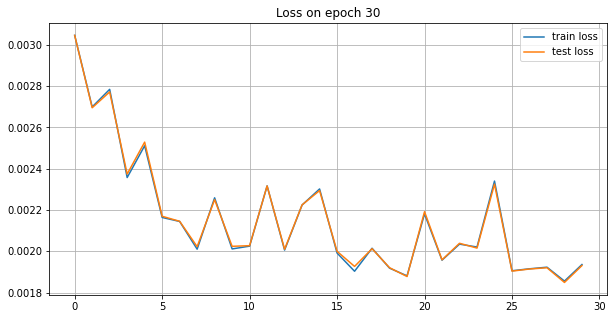

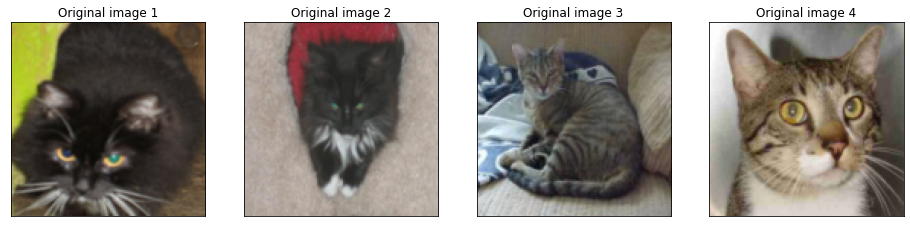

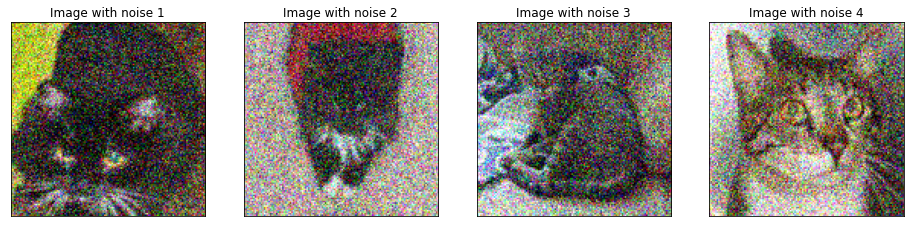

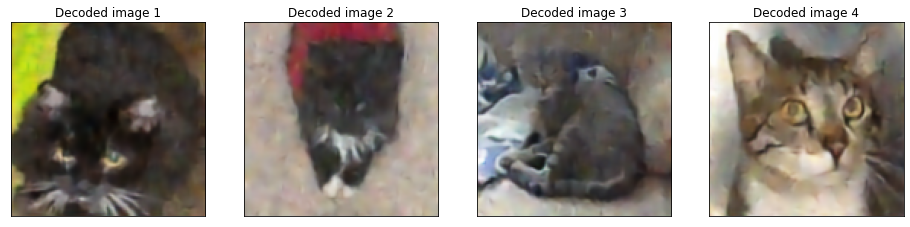

In [61]:
history = torch_train(model, 30)